# Color quantization & first evaluation of color histogram classifier

## Loading the data

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from toolkit import get_data_set

In [2]:
X, Y = get_data_set()
X.shape, Y.shape

((285,), (285,))

## What the data looks like ?

In [3]:
nb_class = np.max(Y)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(X[Y == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Image mask

In [4]:
gray_threshold = 245

masks = np.array([
    np.array(img.sum(axis=-1) < (gray_threshold * 3),
             dtype=np.uint8)
    for img in X
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [19]:
moments = np.array([cv.moments(mask, binaryImage=True) for mask in masks])
hu_moments = np.array([cv.HuMoments(mask_moments)[:-1] for mask_moments in moments])
hu_moments = hu_moments.reshape(285, 6)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    print("Hu moments of order 0:")
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    mask_moments = hu_moments[Y == class_]
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')
        ax_arr[i].axis("off")
        ax_arr[i].set_title(np.round(mask_moments[i][0], 2))

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier()
cross_val_score(knn, hu_moments, Y, cv=5)

array([0.92982456, 0.9122807 , 0.94736842, 0.9122807 , 0.92982456])

In [10]:
from sklearn.svm import SVC

svc = SVC()
cross_val_score(svc, hu_moments, Y, cv=5)

array([0.9122807 , 0.92982456, 0.94736842, 0.85964912, 0.92982456])

In [11]:
from sklearn.model_selection import cross_validate

dict_ = cross_validate(knn, hu_moments, Y, cv=5, return_estimator=True)
dict_["test_score"]

array([0.92982456, 0.9122807 , 0.94736842, 0.9122807 , 0.92982456])

In [12]:
best_knn = dict_["estimator"][1]

In [13]:
dict_svc = cross_validate(svc, hu_moments, Y, cv=5, return_estimator=True)
dict_svc["test_score"]

array([0.9122807 , 0.92982456, 0.94736842, 0.85964912, 0.92982456])

In [14]:
best_svc = dict_svc["estimator"][1]

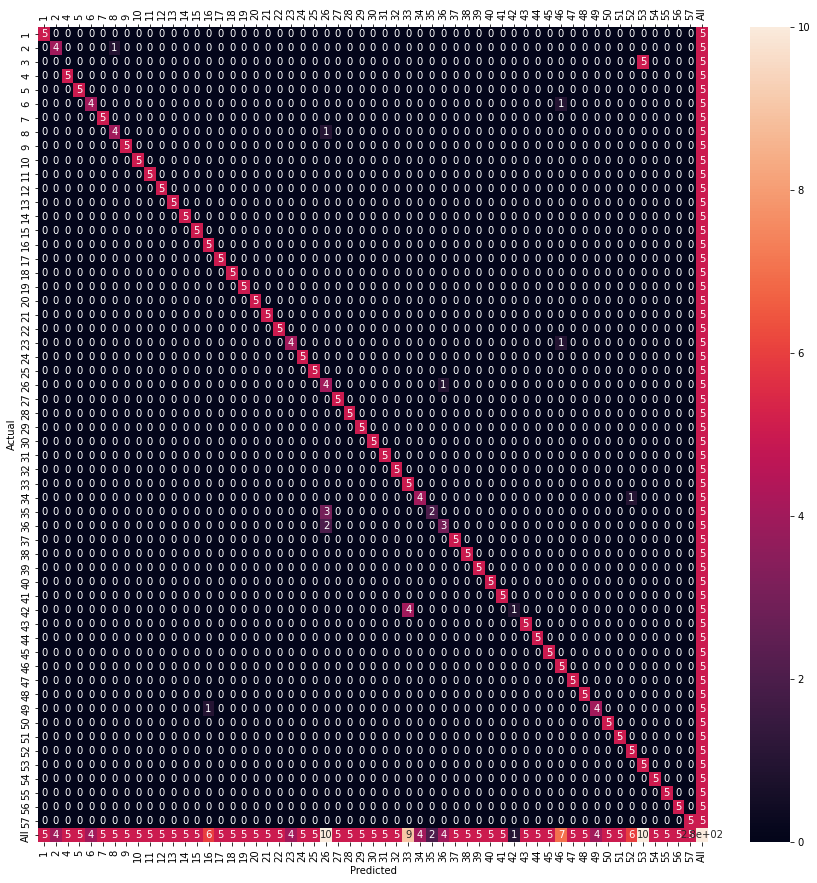

In [15]:
import pandas as pd
import seaborn as sn

def print_confusion_matrix(predicted: np.array, actual: np.array) -> None:
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))
    plt.show()
    
plt.rcParams["figure.figsize"] = (15,15)
print_confusion_matrix(best_knn.predict(hu_moments), Y)